In [1]:
!pip install numba

from numba import cuda

dev = cuda.get_current_device(); dev.reset()

In [ ]:
for dev in device_lib.list_local_devices(): # 사용가능한 device(CPU, GPU 등) 목록
    print(dev.device_type, dev.memory_limit)

# #Library

In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import shutil
import pickle
import zipfile

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# #Function

In [2]:
Index2Label = {0: 'Background',
               1: 'Head',
               2: 'Torso',
               3: 'Upper_Arms',
               4: 'Lower_Arms',
               5: 'Upper_Legs',
               6: 'Lower_Legs'}

Label2Index = {'Background': 0,
               'Head': 1,
               'Torso': 2,
               'Upper_Arms': 3,
               'Lower_Arms': 4,
               'Upper_Legs': 5,
               'Lower_Legs': 6}

# Label2Index = {v: k for k, v in Index2Label.items()}

In [3]:
def create_images_path(folder_path):
    folder_path = folder_path
    imges = os.listdir(folder_path)
    images_path = [os.path.join(folder_path, img) for img in imges]
    return images_path


def visualize_images(images_path, visualize=1, rotate=0): # Outputs\\01_01_F010_02.png, rotate 회전각 입력
    # Output
    images_names = []
    images_array = []

    for img in tqdm(images_path, desc="Processing images"):
        image_path = img
        image_name = os.path.basename(image_path)

        image = Image.open(image_path)

        # 이미지 회전 메타데이터를 자동으로 해석하여 회전시킴
        image = image.rotate(rotate, expand=True)  # 0은 회전 각도, expand=True는 이미지 크기 조정 (0 / 270)

        images_names.append(image_name)
        image_array = np.array(image)
        images_array.append(image_array)

        # Visualize Images -------------------> Option(On/Off)
        if visualize:

            print("Size of Image:", image.size)
            print("Mode of Image:", image.mode) # (RGB/L/P)

            # print("Shape of Image (Numpy ):", )


            plt.imshow(image)
            plt.title(f'{image_name}')
            plt.axis('off')  # 축 제거
            plt.show()
    else:
        pass

    return images_names, images_array


def palette_to_one_hot(palette_image_path, num_classes=7, imge_info=True, visualize=True):
    """
    팔레트 이미지를 원핫인코딩하여 (2940, 1960, 7) 형태의 이미지로 변환하는 함수

    Args:
    palette_image_path (str): 세그멘테이션된 P 모드의 PIL 팔레트 이미지 경로

    Returns:
    np.ndarray: 원핫인코딩된 이미지
    """
    # 클래스 수 정의 (배경 포함 1개)
    num_classes = num_classes

    # PIL 2 Numpy
    palette_image = Image.open(palette_image_path)
    palette_image_array = np.array(palette_image)

    # 원핫인코딩된 이미지를 저장할 배열 생성
    one_hot_encoded_image = np.zeros((*palette_image_array.shape, num_classes), dtype=np.uint8)

    # 각 픽셀을 원핫인코딩된 형태로 변환
    for i in range(palette_image_array.shape[0]): # 2940
        for j in range(palette_image_array.shape[1]): # 1960
            pixel_value = palette_image_array[i, j]  # 현재 픽셀의 값
            one_hot_encoded_image[i, j, pixel_value] = 1  # 해당 클래스에 대응하는 채널에 1 할당

    if imge_info:
        # 이미지 이름 출력
        image_name = os.path.basename(palette_image_path)
        print("Image Name:", image_name)
        print("Original Image Shape:", palette_image_array.shape)
        print("Transformed Image Shape:", one_hot_encoded_image.shape)
        print()

    if visualize:
        visualize_one_hot_encoded_image(one_hot_encoded_image,  Index2Label=Index2Label)

    return one_hot_encoded_image


def visualize_one_hot_encoded_image(one_hot_encoded_image, Index2Label=Index2Label):
    """
    원핫인코딩된 이미지를 시각화하고 클래스별로 따로 시각화하여 보여주는 함수

    Args:
    one_hot_encoded_image (np.ndarray): 원핫인코딩된 이미지

    Returns:
    None
    """
    # 이미지의 형태 출력
    print("Transformed Image Shape:", one_hot_encoded_image.shape)

    # 전체 이미지 시각화
    plt.figure(figsize=(8, 8))
    plt.imshow(one_hot_encoded_image.argmax(axis=2), cmap='viridis', interpolation='nearest')
    plt.title('Original Palette Image')
    plt.axis('off')
    plt.show()

    # 클래스별로 따로 시각화
    num_classes = one_hot_encoded_image.shape[2]
    for class_index in range(num_classes):
        class_image = one_hot_encoded_image[:, :, class_index]
        plt.figure(figsize=(8, 8))
        plt.imshow(class_image, cmap='gray')
        plt.title(f'Class: {class_index} {Index2Label[class_index]}')
        plt.axis('off')
        plt.show()


def save_images_pkl_with_one_hot_encoding(images_paths, output_folder_path, num_classes=7, imge_info=True, visualize=False):
    """
    이미지를 원핫인코딩하여 새로운 폴더에 저장하는 함수

    Args:
    images_paths (list): 이미지 파일 경로의 리스트
    output_folder_path (str): 이미지를 저장할 폴더 이름(현재 경로에 저장)
    num_classes (int): segmentation 세그멘테이션 클래스 개수(배경 포함)
    imge_info (bool): 이미지 정보 출력 토글(default: True)
    visualize (bool): 이미지 시각화 토글(default: False)

    Returns:
    None
    """
    # 새로운 폴더 생성
    os.makedirs(output_folder_path, exist_ok=True)

    # one_hot_encoded_images
    one_hot_encoded_images = []

    # 원핫 인코딩 수행
    for img_path in tqdm(images_paths, desc='Encoding images'):

        # PIL Pallete 2 Numpy
        one_hot_encoded_image = palette_to_one_hot(img_path, num_classes=num_classes, imge_info=imge_info, visualize=visualize)
        one_hot_encoded_images.append(one_hot_encoded_image)

    # 저장할 경로 설정
    save_path = os.path.join(output_folder_path, f"one_hot_encoded_images_array.pkl")

    # 이미지 데이터를 피클로 저장
    with open(save_path, 'wb') as f:
        pickle.dump(one_hot_encoded_images, f)

# #Load Data

In [4]:
!pip install gdown

이미지

#### 미란 리사이즈

In [7]:
!gdown --id 1Idd9s_0uoiXFeGTfXDXesiSU-4unUiok

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Idd9s_0uoiXFeGTfXDXesiSU-4unUiok
To: /content/01.zip
100% 17.2M/17.2M [00:00<00:00, 142MB/s]


In [8]:
zip_file_path = '/content/01.zip'  # 압축 파일 경로
extract_dir = '/content/01'  # 압축을 푸는 디렉토리 경로

# 압축 파일 열기
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # 압축 해제
    zip_ref.extractall(extract_dir)

In [9]:
origin_path = create_images_path('/content/01/01')
origin_path.sort()
len(origin_path)

872

Processing images:   0%|          | 0/1 [00:00<?, ?it/s]

Size of Image: (512, 512)
Mode of Image: RGB


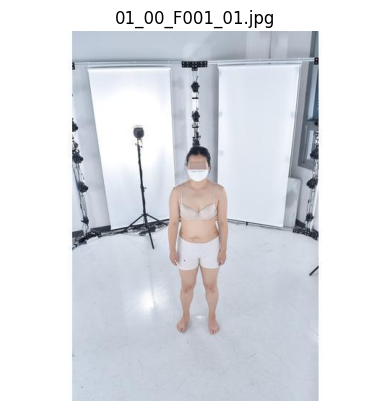

Processing images: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


In [10]:
test = origin_path[:1]

imges_name, imges_array = visualize_images(test, visualize=True, rotate=0)

In [11]:
imges_name, imges_array = visualize_images(origin_path, visualize=False, rotate=0)

Processing images: 100%|██████████| 872/872 [00:01<00:00, 490.42it/s]


In [12]:
X = np.array(imges_array)

X.shape

(872, 512, 512, 3)

In [13]:
del imges_array

#### 원본으로 리사이즈

In [54]:
# del X_train
# del X_test

In [4]:
!gdown --id 1ZzrjGvnLrQbQX7_XCC9La7sPHwLsmji7

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1ZzrjGvnLrQbQX7_XCC9La7sPHwLsmji7

but Gdown can't. Please check connections and permissions.


In [5]:
!unzip /content/origin.zip -d /content/Origin_image

unzip:  cannot find or open /content/origin.zip, /content/origin.zip.zip or /content/origin.zip.ZIP.


In [10]:
origin_images_path = create_images_path("/content/Origin_image/img/01")
origin_images_path.sort()
len(origin_images_path)

872

Processing images:   0%|          | 0/1 [00:00<?, ?it/s]

Size of Image: (1960, 2940)
Mode of Image: RGB


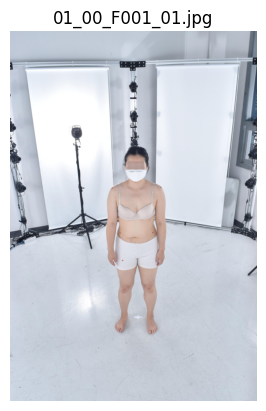

Processing images: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


In [11]:
test = origin_images_path[0:1]
imges_name, imges_array = visualize_images(test, visualize=True, rotate=270)

In [12]:
imges_name, imges_array = visualize_images(origin_images_path[:500], visualize=False, rotate=270)

Processing images: 100%|██████████| 500/500 [00:27<00:00, 18.15it/s]


In [13]:
origin_array = np.array(imges_array)
origin_array.shape

(500, 2940, 1960, 3)

In [14]:
del imges_array

In [36]:
X = []

for image_array in origin_array:
    resized_array = resized_padded_image = tf.image.resize_with_pad(image_array, target_height=512, target_width=512).numpy()
    X.append(resized_array)

X = np.array(X)
X.shape

NameError: name 'origin_array' is not defined

In [16]:
del origin_array

In [17]:
# 피클 파일 경로
# pickle_file_path = '/content/angle_1_origin_resized.pkl'

# with open(pickle_file_path, 'rb') as f:
  # pickle.dump(X, f)

#### 피클

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
pkl_path = "/content/drive/MyDrive/one_hot_encoded_images_array_01.pkl"

with open(pkl_path, 'rb') as f:
  seg_imges = pickle.load(f)

seg_array = np.array(seg_imges[:500])

print(type(seg_imges), len(seg_imges))
print(type(seg_array), seg_array.shape)

<class 'list'> 872
<class 'numpy.ndarray'> (500, 2940, 1960, 7)


In [23]:
y = []

for seg_imge in seg_array:
    resized_array = resized_padded_image = tf.image.resize_with_pad(seg_imge, target_height=512, target_width=512).numpy()
    y.append(resized_array)

y = np.array(y)
y.shape

(500, 512, 512, 7)

In [24]:
# 배열을 삭제하여 메모리 확보
del seg_imges
del seg_array

In [25]:
X.shape, y.shape

NameError: name 'X' is not defined

# #Model
- Standard UNET

In [14]:
def conv_block(inputs, filters, kernel_size=3):
    x = layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(inputs)
    x = layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
    return x

def upconv_block(inputs, filters, kernel_size=2):
    x = layers.UpSampling2D(size=(2, 2))(inputs)
    x = layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
    return x

def unet(img_size, num_classes):
    inputs = tf.keras.Input(shape=img_size + (3,))

    # Contracting Path
    c1 = conv_block(inputs, 64, kernel_size=3)
    p1 = layers.MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = conv_block(p1, 128, kernel_size=3)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = conv_block(p2, 256, kernel_size=3)
    p3 = layers.MaxPooling2D(pool_size=(2, 2))(c3)

    c4 = conv_block(p3, 512, kernel_size=3)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottom
    b = conv_block(p4, 1024, kernel_size=3)

    # Expanding Path
    u1 = upconv_block(b, 512, kernel_size=2)
    u1_concat = layers.Concatenate()([u1, c4])
    c5 = conv_block(u1_concat, 512, kernel_size=3)

    u2 = upconv_block(c5, 256, kernel_size=2)
    u2_concat = layers.Concatenate()([u2, c3])
    c6 = conv_block(u2_concat, 256, kernel_size=3)

    u3 = upconv_block(c6, 128, kernel_size=2)
    u3_concat = layers.Concatenate()([u3, c2])
    c7 = conv_block(u3_concat, 128, kernel_size=3)

    u4 = upconv_block(c7, 64, kernel_size=2)
    u4_concat = layers.Concatenate()([u4, c1])
    c8 = conv_block(u4_concat, 64, kernel_size=3)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c8)

    return tf.keras.Model(inputs, outputs)

In [15]:
# Clearing previous sessions
tf.keras.backend.clear_session()

In [16]:
img_size = (512, 512)
num_classes = 7

In [17]:
unet = unet(img_size, num_classes)

unet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 256, 256, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

# Training(02.29.Thu)

In [18]:
# 이미지 데이터 정규화
X_normalized = X / 255.0

In [19]:
del X

In [28]:
X = X_normalized[:500]

X.shape, y.shape

((500, 512, 512, 3), (500, 512, 512, 7))

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 512, 512, 3),
 (100, 512, 512, 3),
 (400, 512, 512, 7),
 (100, 512, 512, 7))

In [30]:
del X
del y

In [31]:
print('Number of train images', X_train.shape[0])

num_X_train = X_train.shape[0]
batch_size = 16 # batch_size 일반적으로, 배치 사이즈는 2의 n 거듭제곱으로 잡음
num_batch = X_train.shape[0] // batch_size

print('num_X_train:', num_X_train)
print('batch_size:', batch_size)
print('num_batch:', num_batch)
print(f'residual = {num_X_train}-{batch_size}x{num_batch} =', num_X_train-batch_size*num_batch)

Number of train images 400
num_X_train: 400
batch_size: 16
num_batch: 25
residual = 400-16x25 = 0


In [32]:
# Call Backs: Early Stopping
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

In [37]:
# Model fitting
hist = unet.fit(X_train, y_train, epochs = 50, validation_split=0.2 , batch_size=batch_size, callbacks=[early], verbose=1)


Epoch 1/50
20/20 [==============================] - 10s 508ms/step - loss: nan - accuracy: 0.9477 - val_loss: nan - val_accuracy: 0.9470
Epoch 2/50
20/20 [==============================] - 10s 500ms/step - loss: nan - accuracy: 0.9477 - val_loss: nan - val_accuracy: 0.9470
Epoch 3/50
20/20 [==============================] - 10s 503ms/step - loss: nan - accuracy: 0.9477 - val_loss: nan - val_accuracy: 0.9470
Epoch 4/50
20/20 [==============================] - 10s 503ms/step - loss: nan - accuracy: 0.9477 - val_loss: nan - val_accuracy: 0.9470
Epoch 5/50
20/20 [==============================] - 10s 500ms/step - loss: nan - accuracy: 0.9477 - val_loss: nan - val_accuracy: 0.9470
Epoch 6/50
20/20 [==============================] - 10s 502ms/step - loss: nan - accuracy: 0.9477 - val_loss: nan - val_accuracy: 0.9470
Epoch 7/50
20/20 [==============================] - 10s 506ms/step - loss: nan - accuracy: 0.9477 - val_loss: nan - val_accuracy: 0.9470
Epoch 8/50
20/20 [=======================

In [38]:
# Evaluate
unet.evaluate(X_test, y_test)

4/4 [==============================] - 1s 278ms/step - loss: nan - accuracy: 0.9471


[nan, 0.9471142292022705]

# Train, Validation Grapgh

In [39]:
import plotly.graph_objects as go
import plotly.express as px

def plot_hist(hist):
    fig = go.Figure()

    # Train and Validation Accuracy
    fig.add_trace(go.Scatter(x=[epoch + 1 for epoch in hist.epoch], y=hist.history['accuracy'], mode='lines+markers', name='Train Accuracy', line=dict(color='rgb(190, 82, 243)')))
    fig.add_trace(go.Scatter(x=[epoch + 1 for epoch in hist.epoch], y=hist.history['val_accuracy'], mode='lines+markers', name='Validation Accuracy', line=dict(color='rgb(128, 177, 211)')))

    # Train and Validation Loss with dashed lines
    fig.add_trace(go.Scatter(x=[epoch + 1 for epoch in hist.epoch], y=hist.history['loss'], mode='lines+markers', name='Train Loss', line=dict(color='rgb(244, 109, 67)', dash='dash')))
    fig.add_trace(go.Scatter(x=[epoch + 1 for epoch in hist.epoch], y=hist.history['val_loss'], mode='lines+markers', name='Validation Loss', line=dict(color='rgb(103, 203, 203)', dash='dash')))

    # Update layout
    fig.update_layout(title='Training History',
                      xaxis=dict(title='Epoch'),
                      yaxis=dict(title='Value'),
                      template='plotly_dark')  # plotly_dark / plotly_white

    # Show plot
    fig.show()

In [40]:
# Assuming you have a 'hist' object after training
plot_hist(hist)